### Import the librabries 

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import scipy 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

%matplotlib inline


In [2]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

In [3]:
cur.execute(
"""
SELECT name from sqlite_master
WHERE type="table";
""")

In [4]:
cur.fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

In [5]:
!dir

/bin/sh: dir: command not found


### Define Functions

In [61]:
def sql_with_cols(query,cursor=cur):
  
  result = cursor.execute(query).fetchall()
  cols = tuple([description[0] for description in cur.description])
  
  full_result = (cols, result[:])
  return full_result

def df_sql(query, cursor=cur):
    cols, result_data = sql_with_cols(query, cursor)
    return pd.DataFrame(data=result_data, columns=cols)

In [ ]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [ ]:
#Two sample T-Test
def two_sample_ttest(a, b)

In [ ]:
#Welch's T Test for Samples with different variances
def welch_t(a, b):
    
    """ Calculate Welch's t statistic for two samples. """
    
    numerator = a.mean() - b.mean()
    
    # “ddof = Delta Degrees of Freedom”: the divisor used in the calculation is N - ddof, 
    #  where N represents the number of elements. By default ddof is zero.
    
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    t = np.abs(numerator/denominator)
    
    return t

def welch_df(a, b):
    
    """ Calculate the effective degrees of freedom for two samples. """
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    df = numerator/denominator
    
    return round(df, 0)
   
     #Return the degrees of freedom

def p_value(a, b, two_sided=False):
    
    t = welch_t(a,b)
    df = welch_df(a,b)
    
    p = 1 - stats.t.cdf(t, df)
    
    if two_sided:
        return 2*p
    else:
        return p
    

In [62]:
df_A = df_sql(
"""
SELECT * FROM OrderDetail
WHERE Discount = 0
""")

In [63]:
df_A.groupby(['OrderId','ProductId'])['Quantity'].sum();

In [64]:
df_B = df_sql(
"""
SELECT * FROM OrderDetail
WHERE Discount IS NOT 0
""")

In [65]:
df_B.groupby(['OrderId','ProductId'])['Quantity'].sum();

### Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

H0: Discount amount does not have a significant effect on the quantity of a product in an order
H1: Discount amount does have a significant effect on the quantity of a product in an order

In [10]:
#Product, Order, Discount, Quantity 

In [66]:
df = df_sql("""
SELECT OrderId, Sum(Quantity) as quantity, Avg(Discount) as avg_dis FROM OrderDetail

GROUP BY OrderId;

""")
df.head()

,OrderId,quantity,avg_dis
0,10248,27,0.000000
1,10249,49,0.000000
2,10250,60,0.100000
3,10251,41,0.033333
4,10252,105,0.033333


In [12]:
#A: NO DISCOUNT
#B: HAS DISCOUNT
df_nodiscount = df[df['avg_dis']==0]

df_discount= df[df['avg_dis']>0]

In [13]:
a=df_nodiscount['quantity']


In [14]:
b=df_discount['quantity']

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


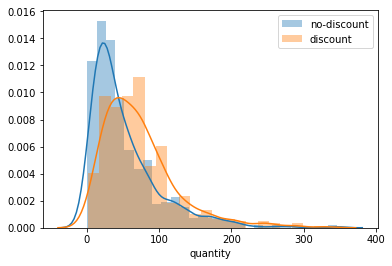

In [15]:
sns.distplot(a, label='no-discount')
sns.distplot(b, label='discount')
plt.legend()

#### Because of Central Limit Theorem, we can 2 Sample T Test

In [16]:
stats.ttest_ind(a,b)

Ttest_indResult(statistic=-5.91731561103876, pvalue=4.7876655924928625e-09)

#### Non Parametric KS Test

In [17]:
#the distributions
stats.ks_2samp(a,b)

Ks_2sampResult(statistic=0.26900584795321636, pvalue=1.3184694069188487e-13)

#### Mann-Whitney Test

In [18]:
#Non Parametric equivalent of t tests
stats.mannwhitneyu(a,b)

MannwhitneyuResult(statistic=59105.0, pvalue=8.524065415288705e-15)

In [19]:
#Confidence level of 95%
alpha = 0.05

Reject the null. 

### Effect Size

In [20]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [21]:
abs(Cohen_d(a,b))

0.4122521666326047

### Cohen's D shows the difference is small to medium

### Next examine different levels of discount (one-way ANOVA)

In [ ]:
#Do Tukey's after Anova, Tukey makes your alpha even smaller.

## Question Exploration 
- Is there a different impact of discount on different categories?bb
- What category sell more? - If category A sell more than category B
- What category sell more in winter vs summer?
- What Region do well? 8 Regions
- What are the most popular product?
- Customer location vs order location? If customers order for themselves or for other people?
- Some employees are good at selling specific categories?
- If managers make more money than their subordinates?



### Brain storming - Metrics
- Discount
- Revenue
- Price
- Numer of sales
- Units in stock
- Customer location (location based sales?)
- Quantity
- Seasonality (holiday vs summer)
- Product Category
- Product Price



In [42]:
cur.execute(
"""
SELECT *
FROM "Order"

;


""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [47]:
df['ShipRegion'].nunique()

9

In [52]:
cur.execute(
"""
SELECT *
FROM Employee

;


""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp
2,3,Leverling,Janet,Sales Representative,Ms.,1995-08-30,2024-04-01,722 Moss Bay Blvd.,Kirkland,North America,98033,USA,(206) 555-3412,3355,None,Janet has a BS degree in chemistry from Boston...,2.0,http://accweb/emmployees/leverling.bmp
3,4,Peacock,Margaret,Sales Representative,Mrs.,1969-09-19,2025-05-03,4110 Old Redmond Rd.,Redmond,North America,98052,USA,(206) 555-8122,5176,None,Margaret holds a BA in English literature from...,2.0,http://accweb/emmployees/peacock.bmp
4,5,Buchanan,Steven,Sales Manager,Mr.,1987-03-04,2025-10-17,14 Garrett Hill,London,British Isles,SW1 8JR,UK,(71) 555-4848,3453,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp
5,6,Suyama,Michael,Sales Representative,Mr.,1995-07-02,2025-10-17,Coventry House Miner Rd.,London,British Isles,EC2 7JR,UK,(71) 555-7773,428,None,Michael is a graduate of Sussex University (MA...,5.0,http://accweb/emmployees/davolio.bmp
6,7,King,Robert,Sales Representative,Mr.,1992-05-29,2026-01-02,Edgeham Hollow Winchester Way,London,British Isles,RG1 9SP,UK,(71) 555-5598,465,None,Robert King served in the Peace Corps and trav...,5.0,http://accweb/emmployees/davolio.bmp
7,8,Callahan,Laura,Inside Sales Coordinator,Ms.,1990-01-09,2026-03-05,4726 - 11th Ave. N.E.,Seattle,North America,98105,USA,(206) 555-1189,2344,None,Laura received a BA in psychology from the Uni...,2.0,http://accweb/emmployees/davolio.bmp
8,9,Dodsworth,Anne,Sales Representative,Ms.,1998-01-27,2026-11-15,7 Houndstooth Rd.,London,British Isles,WG2 7LT,UK,(71) 555-4444,452,None,Anne has a BA degree in English from St. Lawre...,5.0,http://accweb/emmployees/davolio.bmp


In [51]:
df['Region'].nunique()

2